In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns

dataset_partition_path = '/media/iittp/new volume/'
features_dir = os.path.join(dataset_partition_path, 'multispectral_glcm_vege_features')

classes = [os.path.splitext(f)[0] for f in os.listdir(features_dir) if f.endswith('.npz')]
classes_id = {cls:id for id,cls in enumerate(classes)}
print("\n".join([f"ID: {i}, CLASS: {cls}" for i, cls in enumerate(classes)]), "\n")

features = {
    cls: np.load(os.path.join(dataset_partition_path, features_dir, cls + '.npz'))['features']
    for cls in classes
}

FEATURES_STRIDE_LENGTH = 1
features_stride = {
    cls: features[cls][::FEATURES_STRIDE_LENGTH]
    for cls in classes
}

for cls in features_stride:
    print(f"Class {cls}")
    print(f"\tNumber of Images: {features[cls].shape[0]}")
    print(f"\tFeatures per Image: {features[cls].shape[1]}")

ID: 0, CLASS: banana
ID: 1, CLASS: elephant_foot
ID: 2, CLASS: paddy
ID: 3, CLASS: turmeric 

Class banana
	Number of Images: 444
	Features per Image: 146
Class elephant_foot
	Number of Images: 552
	Features per Image: 146
Class paddy
	Number of Images: 612
	Features per Image: 146
Class turmeric
	Number of Images: 444
	Features per Image: 146


In [3]:
def plot_confusion_matrix(conf_matrix, classes=classes, title='Confusion Matrix', cmap='Blues'):
    """
    Plots a confusion matrix with class labels.
    
    Parameters:
    - conf_matrix: A square confusion matrix of shape [N, N].
    - classes: A list of class names corresponding to the rows and columns of the confusion matrix.
    - title: Title of the plot.
    - cmap: Color map for heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes,
                cbar=False, square=True, linewidths=0.5, linecolor='gray')

    plt.title(title)
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')

    plt.show()

In [4]:
# Stack the data and create labels
X = np.vstack([features_stride[cls] for cls in classes])
y_list = list()
for i, cls in enumerate(classes):
    y_list += [i] * features_stride[cls].shape[0]
y = np.array(y_list)

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Random Forest

In [5]:
# Train a Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rf_clf.fit(X_train, y_train)

# Test on test set
y_test_pred = rf_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average=None)
test_recall = recall_score(y_test, y_test_pred, average=None)

class_report = classification_report(y_test, y_test_pred)

print(f"Test Accuracy (Random Forest): {test_accuracy}")
print(f"Test Precision (Random Forest): {test_precision}")
print(f"Test Recall (Random Forest): {test_recall}")
print()

print(f"Classification Report:\n{class_report}")

Test Accuracy (Random Forest): 0.9961013645224172
Test Precision (Random Forest): [0.99166667 0.9921875  1.         1.        ]
Test Recall (Random Forest): [0.99166667 0.9921875  1.         1.        ]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       120
           1       0.99      0.99      0.99       128
           2       1.00      1.00      1.00       156
           3       1.00      1.00      1.00       109

    accuracy                           1.00       513
   macro avg       1.00      1.00      1.00       513
weighted avg       1.00      1.00      1.00       513



In [6]:
# Example: Use cross-validation to assess the performance
cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {cv_scores.mean() * 100:.2f}%")

Cross-validation scores: [0.99675325 0.99350649 0.99350649 0.99350649 0.99348534]
Average cross-validation score: 99.42%


Accuracy for class banana: 0.9917
Accuracy for class elephant_foot: 0.9922
Accuracy for class paddy: 1.0000
Accuracy for class turmeric: 1.0000



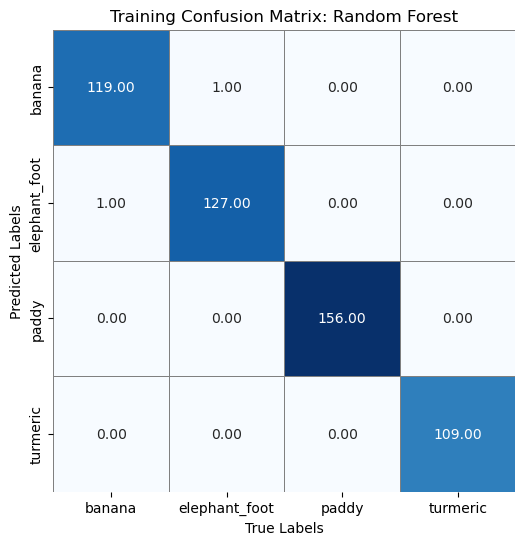

In [7]:
cm = confusion_matrix(y_test, y_test_pred)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

for i, accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {classes[i]}: {accuracy:.4f}")
print()

plot_confusion_matrix(cm, title="Training Confusion Matrix: Random Forest")

In [8]:
with open('model_rf.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

# SVM

SVM Model Accuracy: 51.07%


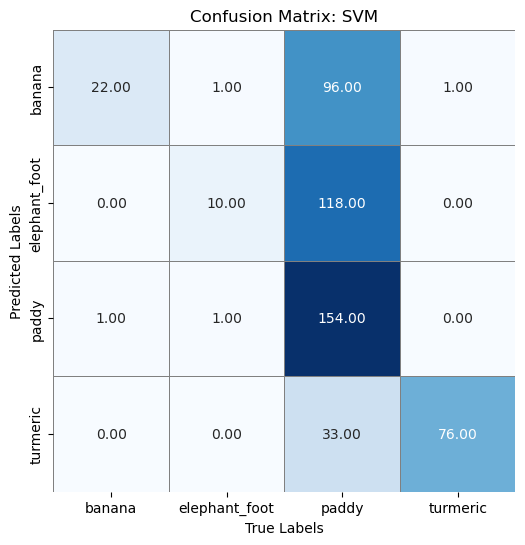

In [9]:
# Initialize the SVM classifier (you can tune the hyperparameters as needed)
svm_clf = SVC(kernel='rbf', C=1, gamma='scale')

# Train the model
svm_clf.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_clf.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_conf_matrix = confusion_matrix(y_test, y_pred_svm)

print(f"SVM Model Accuracy: {svm_accuracy * 100:.2f}%")

plot_confusion_matrix(svm_conf_matrix, title='Confusion Matrix: SVM')

In [10]:
with open('model_svm.pkl', 'wb') as f:
    pickle.dump(svm_clf, f)

# XG-Boost

XGBoost Model Accuracy: 100.00%


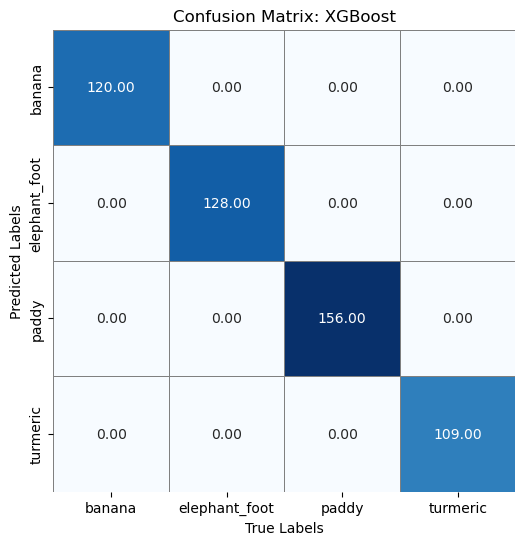

In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(classes),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_conf_matrix = confusion_matrix(y_test, y_pred_xgb)

print(f"XGBoost Model Accuracy: {xgb_accuracy * 100:.2f}%")
plot_confusion_matrix(xgb_conf_matrix, title="Confusion Matrix: XGBoost")

In [12]:
with open('model_xgb.pkl', 'wb') as f:
    pickle.dump(xgb_clf, f)